In [2]:
import numpy as np
import pandas as pd
import pyflux as pf
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

# get data

In [3]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/data/Food_price_indices_data_jul.csv"
food_data = pd.read_csv(datafile)
food_data.head()

,Date,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
0,1/1990,108.7,112.3,94.3,106.4,73.0,201.5
1,2/1990,109.9,117.7,91.9,104.0,72.5,207.9
2,3/1990,107.9,119.6,73.6,102.1,74.6,218.0
3,4/1990,114.2,131.0,85.2,105.1,71.8,216.3
4,5/1990,111.2,130.5,70.0,105.3,74.4,207.2


In [4]:
food_data.tail(12)

,Date,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
330,7/2017,179.0,174.9,216.6,162.2,160.4,207.5
331,8/2017,177.2,174.3,219.7,153.0,164.4,203.9
332,9/2017,178.6,174.0,224.2,151.9,171.9,204.2
333,10/2017,176.5,173.1,214.8,152.7,170.0,203.5
334,11/2017,175.7,172.8,204.2,153.1,172.2,212.7
335,12/2017,169.1,169.7,184.4,152.4,162.6,204.1
336,1/2018,168.4,167.5,179.9,156.6,163.1,199.9
337,2/2018,171.4,170.3,191.1,161.3,158.0,192.4
338,3/2018,173.2,171.0,197.4,165.4,156.8,185.5
339,4/2018,174.0,170.4,204.1,168.5,154.6,176.1


In [5]:
datafile2 = curr_directory + "/data/GLB.Ts+dSST.csv"
temperature_data = pd.read_csv(datafile2)
temperature_data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.29,-0.18,-0.11,-0.19,-0.11,-0.23,-0.20,-0.09,-0.15,-0.23,-0.2,-0.22,-0.18,***,***,-0.14,-0.17,-0.19
1,1881,-0.15,-0.17,0.04,0.04,0.02,-0.20,-0.06,-0.02,-0.13,-0.2,-0.21,-0.1,-0.09,-0.1,-0.18,0.04,-0.09,-0.18
2,1882,0.15,0.15,0.04,-0.18,-0.16,-0.25,-0.20,-0.05,-0.09,-0.24,-0.16,-0.24,-0.1,-0.09,0.07,-0.10,-0.17,-0.16
3,1883,-0.31,-0.38,-0.12,-0.17,-0.20,-0.12,-0.08,-0.15,-0.2,-0.14,-0.22,-0.15,-0.19,-0.19,-0.31,-0.16,-0.11,-0.19
4,1884,-0.15,-0.08,-0.37,-0.42,-0.36,-0.40,-0.34,-0.26,-0.27,-0.24,-0.29,-0.27,-0.29,-0.28,-0.13,-0.38,-0.33,-0.27


# clean the data

In [6]:
from cleaning import cleaning

In [8]:
clean_temp_data = cleaning.clean_temperature_data_step1(temperature_data)

In [10]:
clean_temp_data = cleaning.clean_temperature_data_step2(clean_temp_data)

In [11]:
clean_temp_data.dtypes

Date           datetime64[ns]
Temperature           float64
dtype: object

In [12]:
clean_food_data = cleaning.clean_food_data(food_data)

In [13]:
clean_food_data['Temperature'] = clean_temp_data['Temperature']

In [14]:
clean_food_data.tail()

,Date,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Temperature
337,2018-02-01,170.3,191.1,161.3,158.0,192.4,0.81
338,2018-03-01,171.0,197.4,165.4,156.8,185.5,0.91
339,2018-04-01,170.4,204.1,168.5,154.6,176.1,0.87
340,2018-05-01,169.3,215.2,172.6,150.6,175.3,0.82
341,2018-06-01,169.8,213.2,166.2,146.1,177.4,0.76


In [14]:
# export cleaned and combined data to csv file
#clean_food_data.to_csv('clean_food_data.csv')

In [15]:
indexed_df = clean_food_data.set_index(['Date'])

# Data exploration and visualization
don't forget that the data is on a scale of 2002-2004 = 100.0

In [16]:
indexed_df.describe()

,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Temperature
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,135.943860,140.497661,137.465789,134.756140,182.055848,0.565058
std,30.528729,57.171255,50.422226,53.183568,74.248813,0.215068
min,84.500000,66.100000,80.200000,57.100000,72.900000,0.000000
25%,113.950000,93.425000,97.850000,90.950000,127.850000,0.410000
50%,128.850000,117.200000,113.400000,122.950000,166.850000,0.560000
75%,162.075000,189.100000,165.850000,166.550000,218.950000,0.700000
max,212.000000,275.400000,267.700000,286.500000,420.200000,1.340000


In [17]:
indexed_df.head()

,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Temperature
Date,,,,,,
1990-01-01,112.3,94.3,106.4,73.0,201.5,0.41
1990-02-01,117.7,91.9,104.0,72.5,207.9,0.41
1990-03-01,119.6,73.6,102.1,74.6,218.0,0.76
1990-04-01,131.0,85.2,105.1,71.8,216.3,0.55
1990-05-01,130.5,70.0,105.3,74.4,207.2,0.46


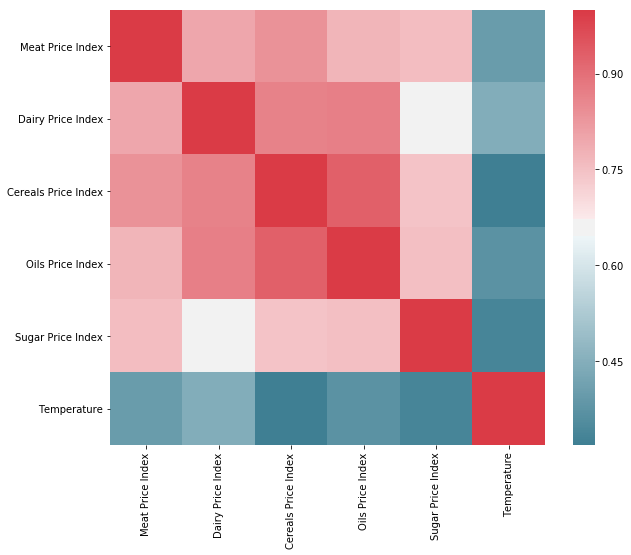

In [18]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = indexed_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


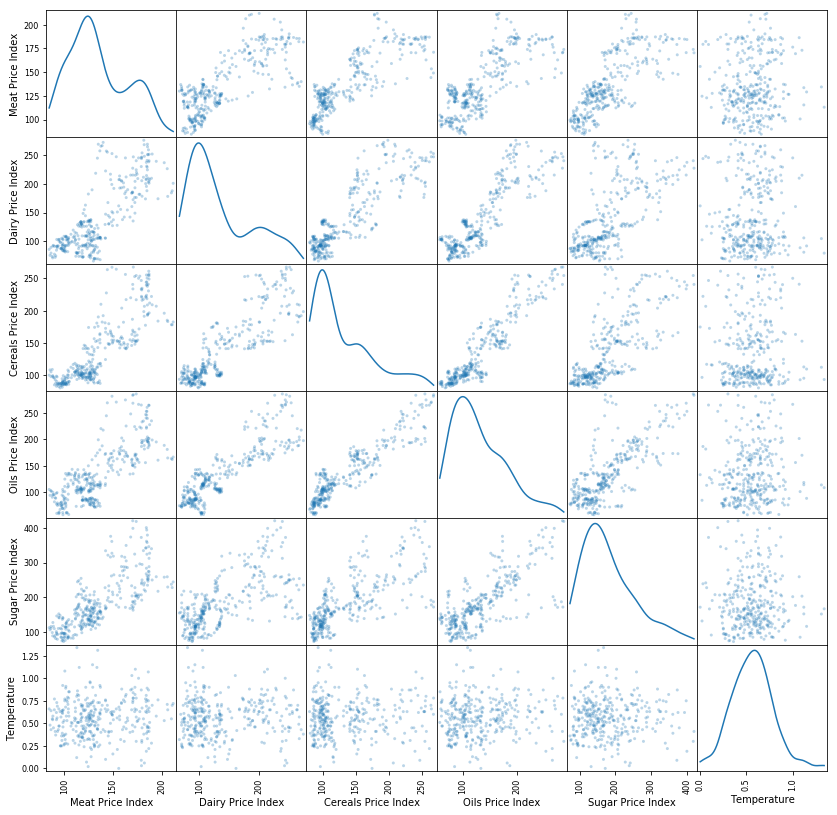

In [78]:
pd.plotting.scatter_matrix(indexed_df, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [79]:
# checking for collinearity
food_corr = np.corrcoef(indexed_df, rowvar=False)
eig_val, eig_vec = np.linalg.eig(food_corr)
eig_val

array([4.21331106, 1.00150663, 0.37066726, 0.22398565, 0.05751236,
       0.13301704])

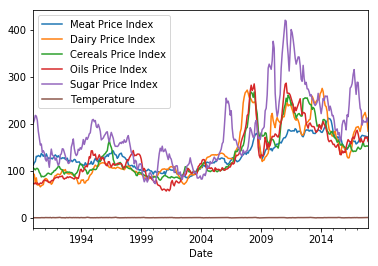

In [80]:
indexed_df.plot()
plt.show()

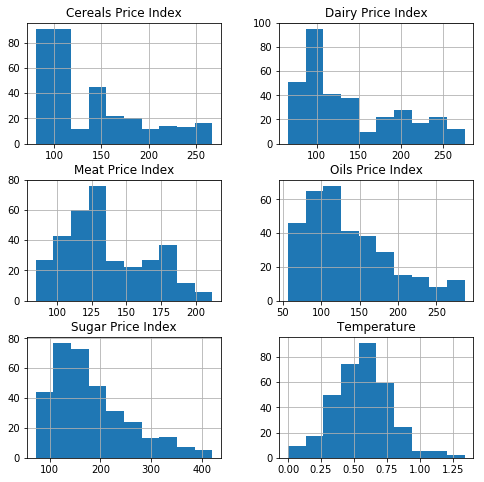

In [81]:
indexed_df.hist(figsize=(8,8))
plt.show()

# feature engineering

In [82]:
from statsmodels.tsa.stattools import adfuller


In [83]:
df_diff = indexed_df.diff()

In [84]:
df_diff.head()

,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Temperature
Date,,,,,,
1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-01,5.4,-2.4,-2.4,-0.5,6.4,-0.01
1990-03-01,1.9,-18.3,-1.9,2.1,10.1,0.04
1990-04-01,11.4,11.6,3.0,-2.8,-1.7,-0.07
1990-05-01,-0.5,-15.2,0.2,2.6,-9.1,-0.10


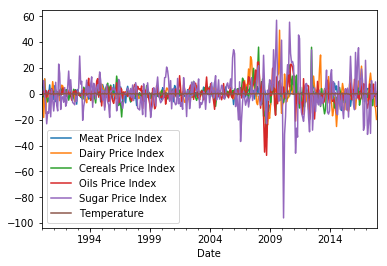

In [85]:
df_diff.plot()
plt.show()

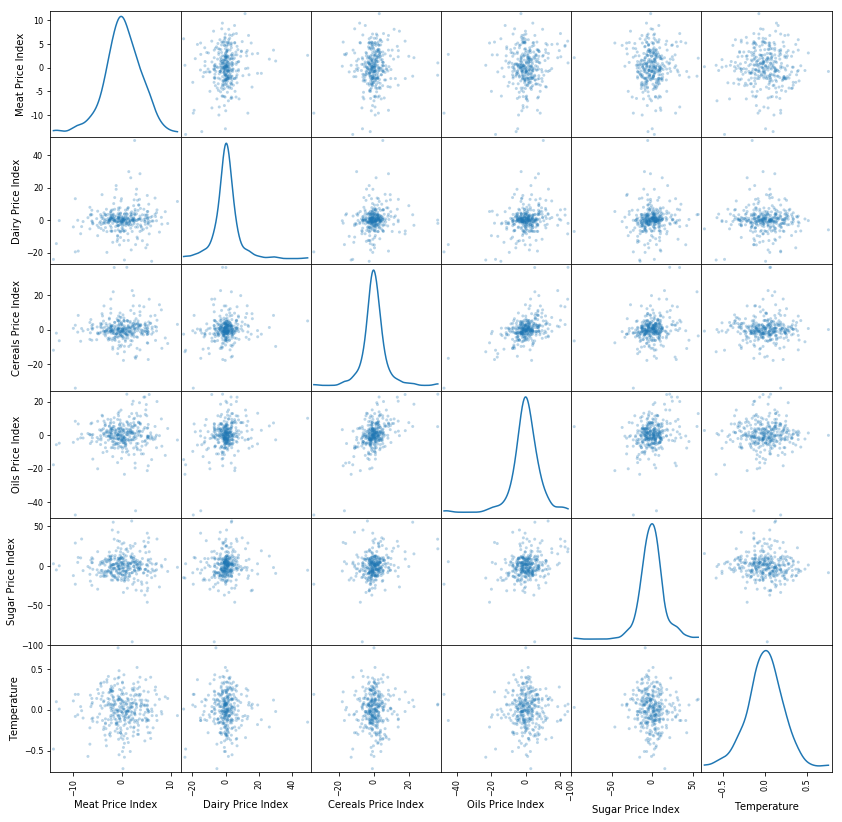

In [86]:
pd.plotting.scatter_matrix(df_diff, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [87]:
def test_fuller(df):
    result = adfuller(df[1:])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [88]:
test_fuller(df_diff['Meat Price Index'])

ADF Statistic: -5.194921
p-value: 0.000009
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [89]:
test_fuller(df_diff['Cereals Price Index'])

ADF Statistic: -4.885484
p-value: 0.000037
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [90]:
test_fuller(df_diff['Dairy Price Index'])

ADF Statistic: -6.605227
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [91]:
test_fuller(df_diff['Oils Price Index'])

ADF Statistic: -5.586205
p-value: 0.000001
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [92]:
test_fuller(df_diff['Sugar Price Index'])

ADF Statistic: -12.099975
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


all adfuller tests show that the differenced data is stationary

next step is to split df into different frames for each index? then to label each frame with if the index went up or down

In [93]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)


In [94]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [95]:
len(indexed_df)

336

In [96]:
year_diff_df = pd.DataFrame()
year_diff_df['Sugar_diff_yr'] = difference(indexed_df['Sugar Price Index'], interval=12)
year_diff_df['Oils_diff_yr'] = difference(indexed_df['Oils Price Index'], interval=12)
year_diff_df['Dairy_diff_yr'] = difference(indexed_df['Dairy Price Index'], interval=12)
year_diff_df['Cereals_diff_yr'] = difference(indexed_df['Cereals Price Index'], interval=12)
year_diff_df['Meat_diff_yr'] = difference(indexed_df['Meat Price Index'], interval=12)
year_diff_df['Temperature_diff_df'] = difference(indexed_df['Temperature'], interval=12)

In [97]:
len(year_diff_df)

324

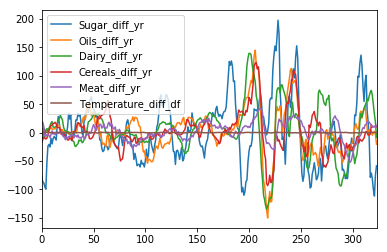

In [98]:
year_diff_df.plot()
plt.show()

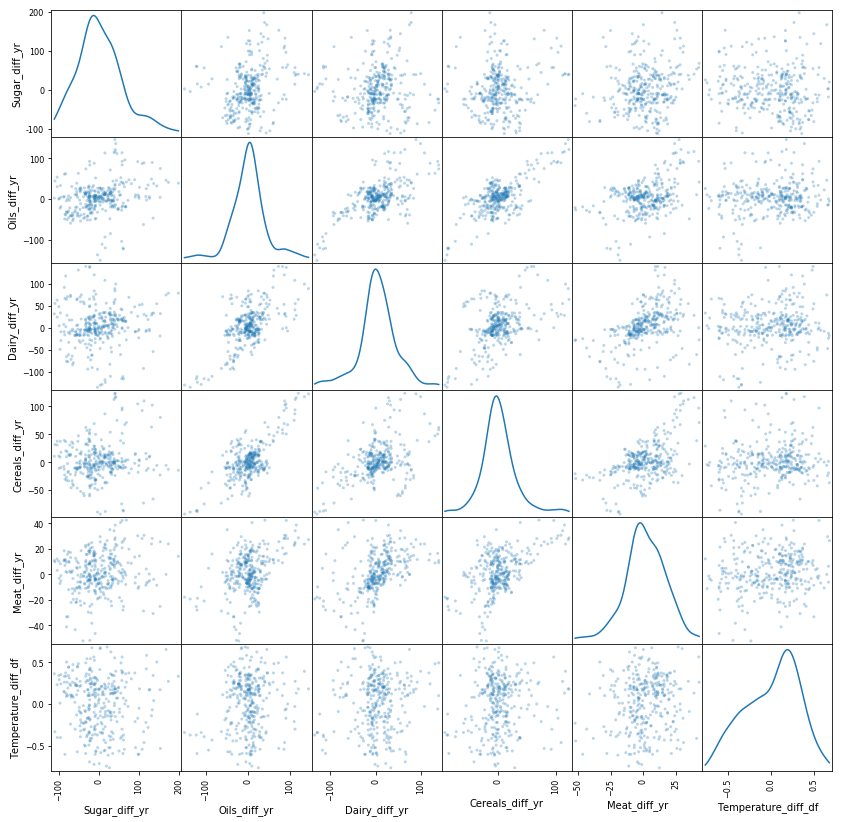

In [99]:
pd.plotting.scatter_matrix(year_diff_df, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [100]:
food_data['Year'], food_data['Month'] = food_data['Date'].dt.year, food_data['Date'].dt.month

food_data['Season_NH'] = food_data['Date'].apply(lambda dt: (dt.month%12 + 3)//3)

In [101]:
food_data.head()

,Date,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Year,Month,Season_NH
0,1990-01-01,108.7,112.3,94.3,106.4,73.0,201.5,1990,1,1
1,1990-02-01,109.9,117.7,91.9,104.0,72.5,207.9,1990,2,1
2,1990-03-01,107.9,119.6,73.6,102.1,74.6,218.0,1990,3,2
3,1990-04-01,114.2,131.0,85.2,105.1,71.8,216.3,1990,4,2
4,1990-05-01,111.2,130.5,70.0,105.3,74.4,207.2,1990,5,2


In [19]:
clean_food_data.head()

,Date,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Temperature
0,1990-01-01,112.3,94.3,106.4,73.0,201.5,0.41
1,1990-02-01,117.7,91.9,104.0,72.5,207.9,0.41
2,1990-03-01,119.6,73.6,102.1,74.6,218.0,0.76
3,1990-04-01,131.0,85.2,105.1,71.8,216.3,0.55
4,1990-05-01,130.5,70.0,105.3,74.4,207.2,0.46


In [15]:
tsfresh_data = pd.melt(clean_food_data, id_vars='Date')

In [17]:
tsfresh_data.columns

Index(['Date', 'variable', 'value'], dtype='object')

In [19]:
tsfresh_data.head()

,Date,variable,value
0,1990-01-01,Meat Price Index,112.3
1,1990-02-01,Meat Price Index,117.7
2,1990-03-01,Meat Price Index,119.6
3,1990-04-01,Meat Price Index,131.0
4,1990-05-01,Meat Price Index,130.5


In [20]:
from tsfresh import extract_features
extracted_features = extract_features(tsfresh_data, column_id='variable', column_sort='Date')

Feature Extraction: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


In [25]:
extracted_features.shape

(6, 794)

# Unsupervised learning

In [102]:
# do some kind of unsupervised learning here

In [37]:
# using tsfresh for feature generation, then PCA for unsupervised learning req

# Supervised Learning

In [103]:
split_point = len(df_diff) - 70
diff_dataset, diff_validation = df_diff[1:split_point], df_diff[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
#dataset.to_csv('dataset.csv')
#validation.to_csv('validation.csv')

Dataset 265, Validation 70


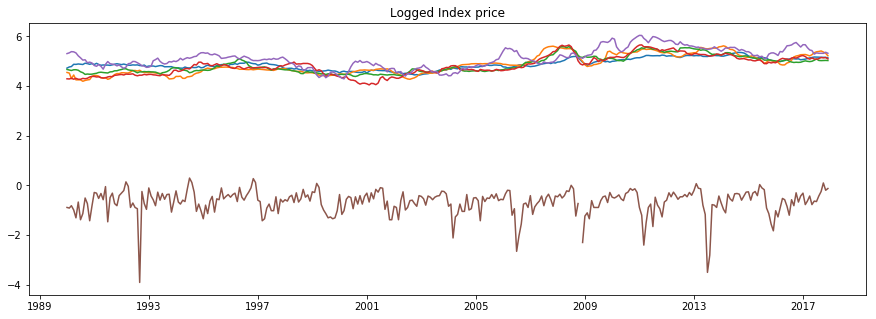

In [124]:
# try VAR from Pyflux
indexed_prices = np.log(indexed_df)
plt.figure(figsize=(15,5));
plt.plot(indexed_prices.index,indexed_prices);
#plt.legend(opening_prices.columns.values,loc=3);
plt.title("Logged Index price");

In [82]:
def VAR_model(df, lags, differences):
    VAR_model = pf.VAR(data=df, lags=lags, integ=differences)
    VARx = VAR_model.fit()
    print(VARx.summary())
    VAR_model.plot_z(list(range(0,6)),figsize=(15,5))
    VAR_model.plot_fit(figsize=(15,5))
    VAR_model.plot_predict(past_values=19, h=5, figsize=(15,5))
    VAR_model.plot_predict_is(h=10, figsize=((15,5)))

VAR(2)                                                                                                    
======================================================= ==================================================
Dependent Variable: Differenced Meat Price Index,Differ Method: OLS                                       
Start Date: 1990-03-01 00:00:00                         Log Likelihood: -5236.0801                        
End Date: 2018-06-01 00:00:00                           AIC: 10670.1603                                   
Number of observations: 339                             BIC: 11048.9343                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Differenced Meat Price Index Constant    0.0586     0.1825     0.3213   0.748    (-0.299 | 0.4162)        
Differenced Meat Price Index AR(1)   

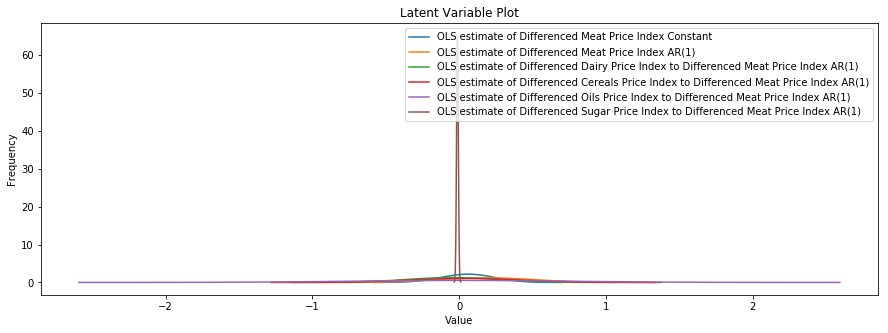

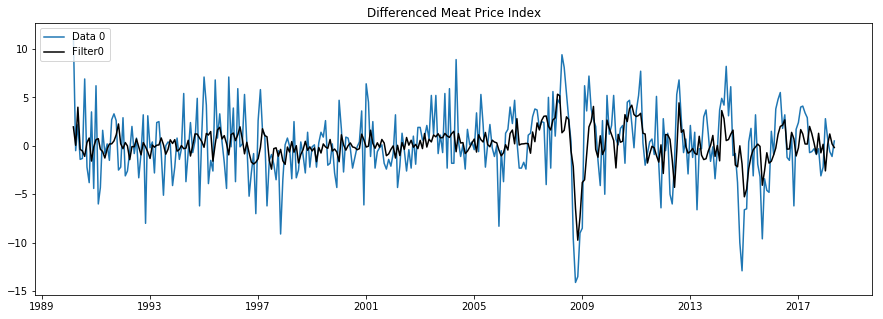

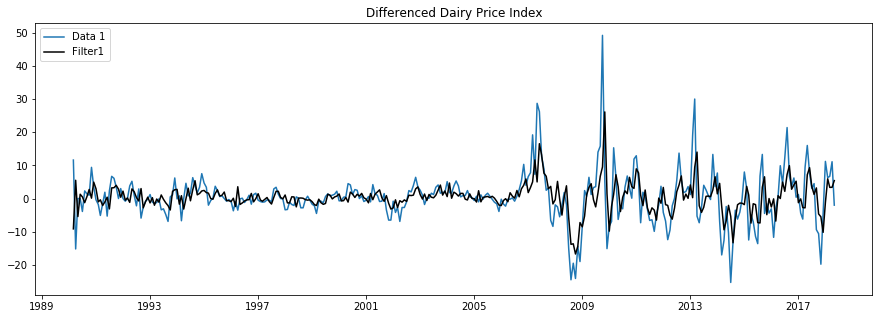

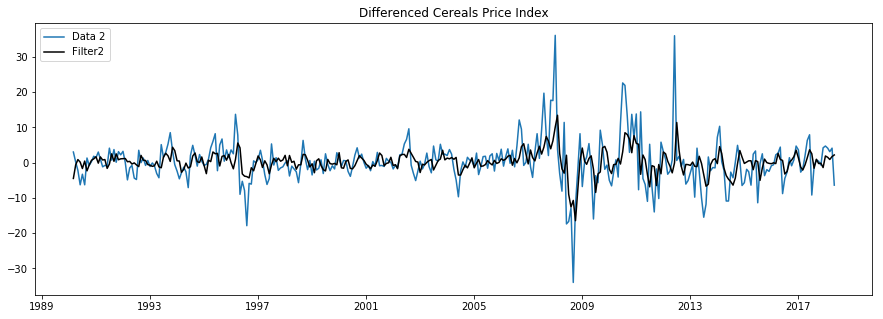

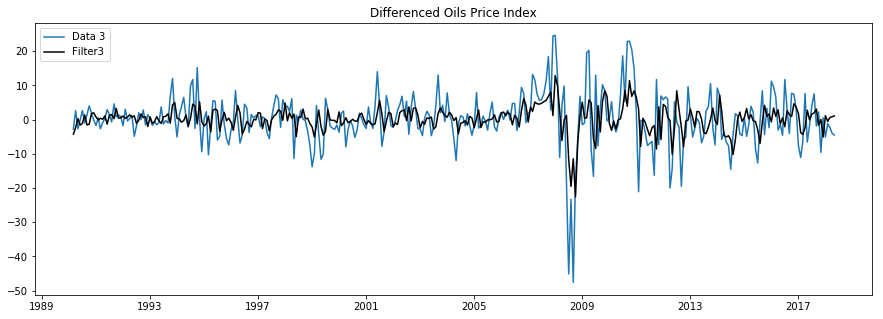

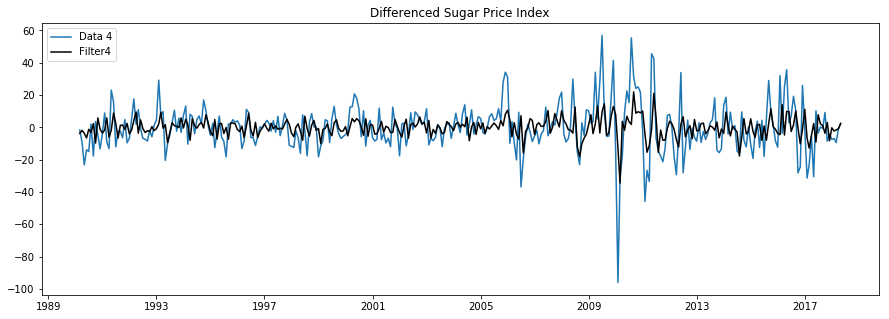

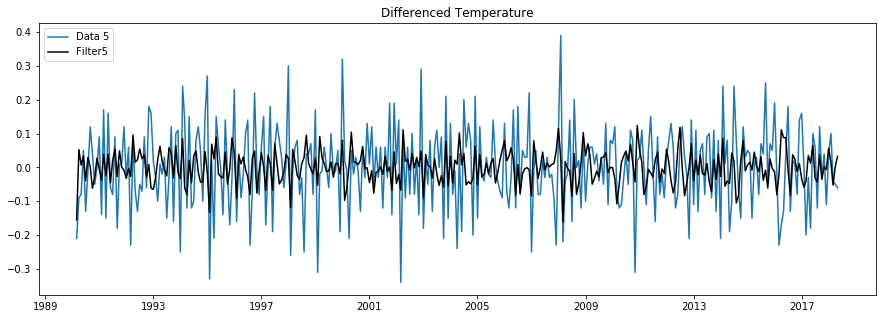

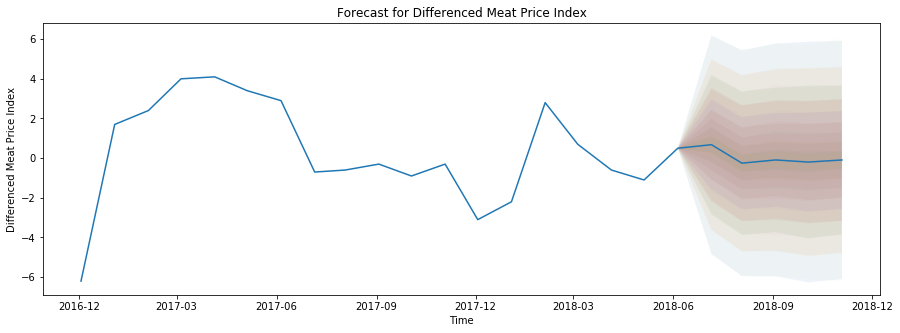

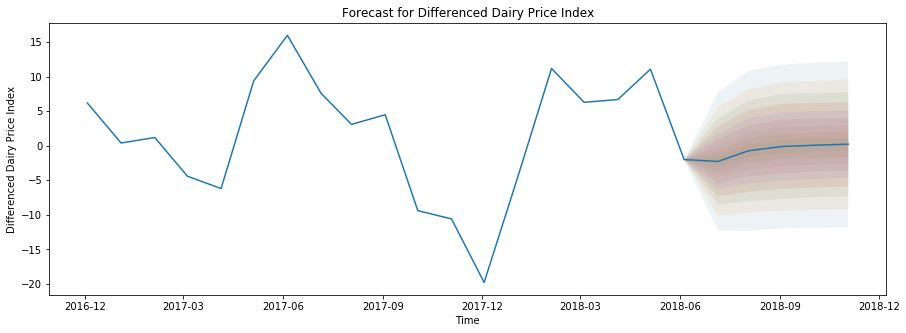

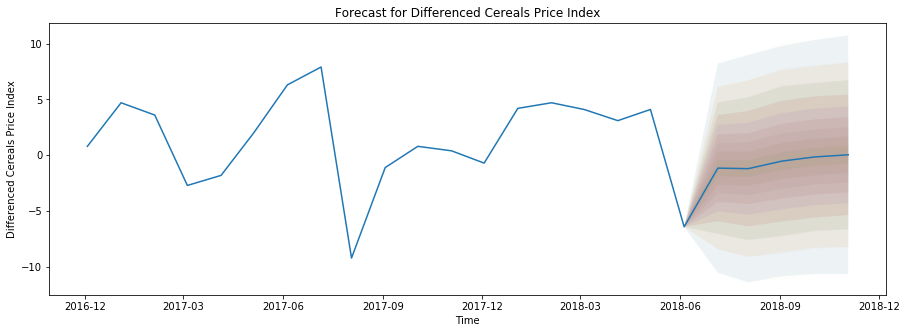

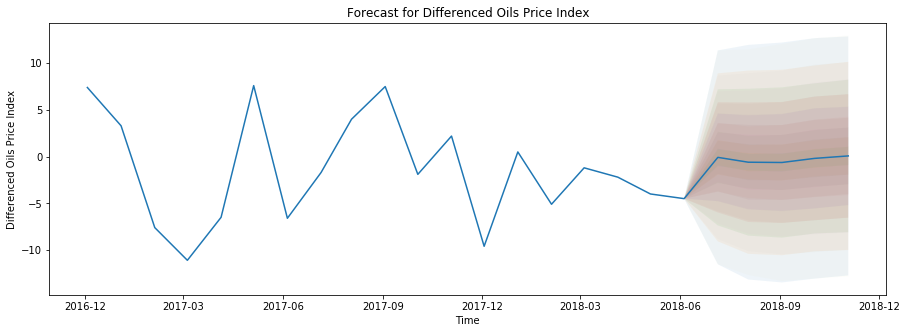

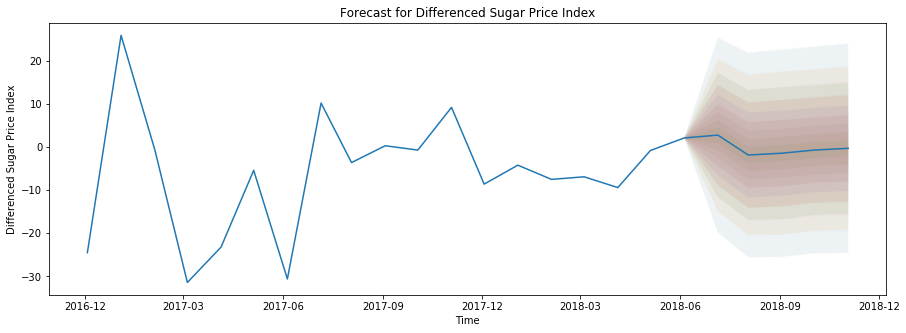

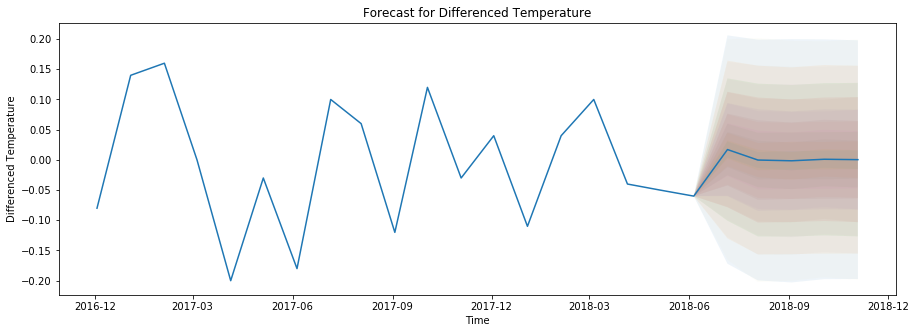

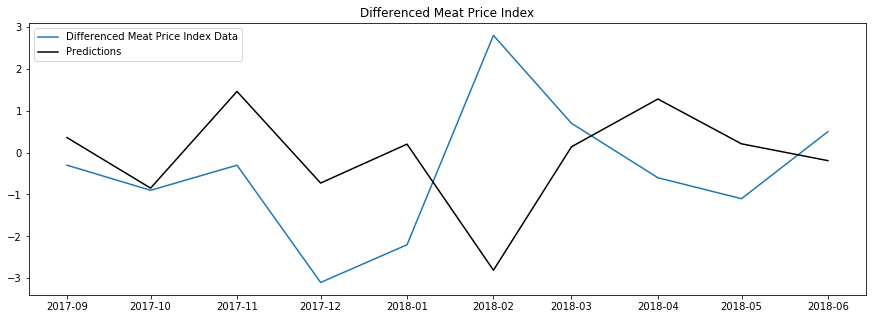

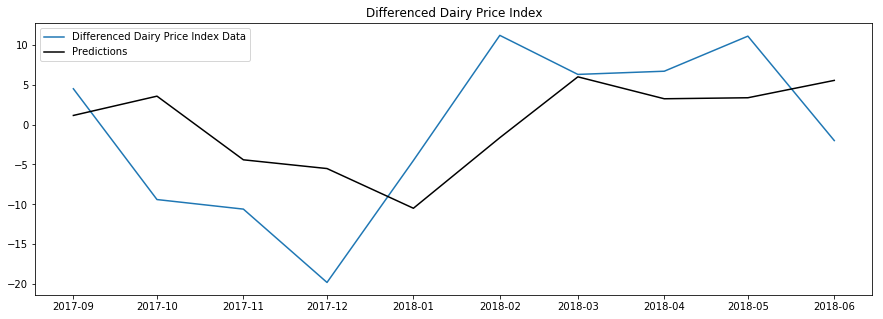

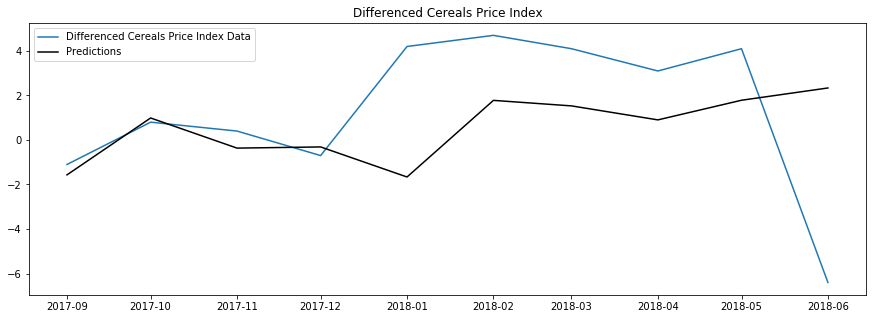

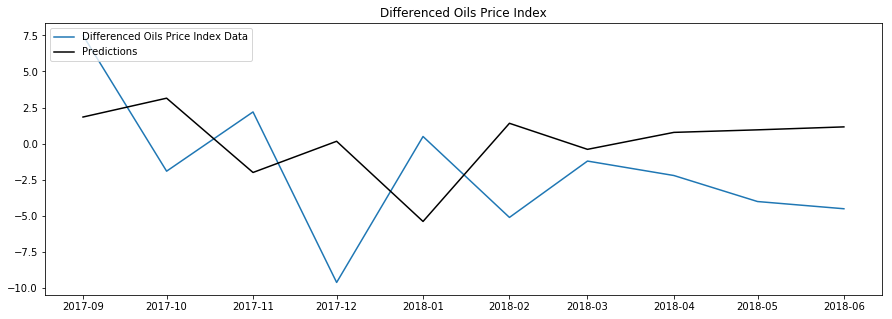

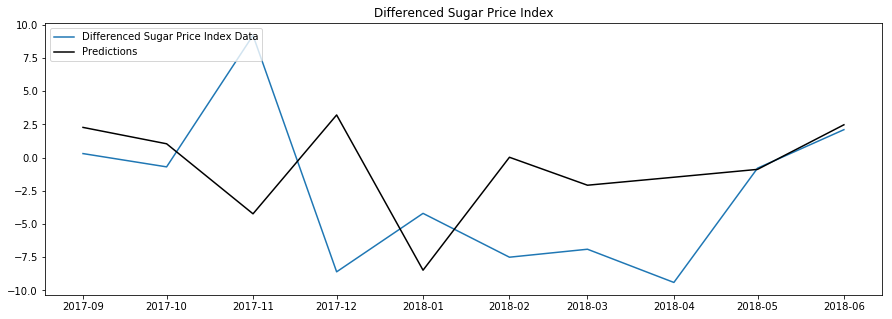

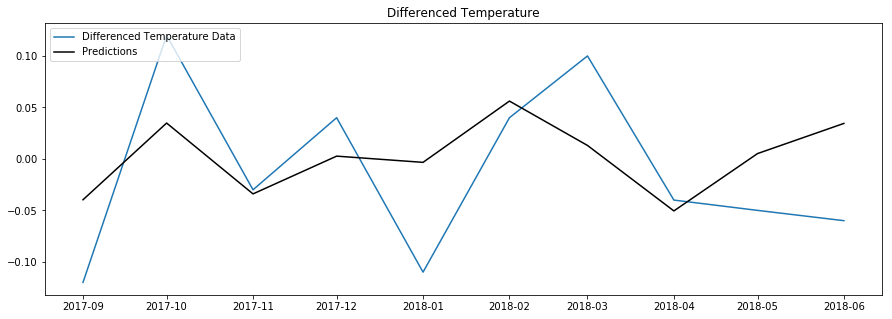

In [83]:
VAR_model(indexed_df, 2, 1)

In [84]:
def ARIMA_model(df, target):
    pfarima_model = pf.ARIMA(data=df, ar=4, ma=4, target=target, family=pf.Normal())
    arima_x = pfarima_model.fit("MLE")
    arima_x.summary()
    arima_x_mh = pfarima_model.fit("M-H")
    arima_x_mh.summary()
    pfarima_model.plot_z(figsize=(15,5))
    pfarima_model.plot_fit(figsize=(15,10))
    pfarima_model.plot_predict_is(h=50, figsize=(15,5))

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Sugar Price Index                   Method: MLE                                       
Start Date: 1990-05-01 00:00:00                         Log Likelihood: -1448.9933                        
End Date: 2018-06-01 00:00:00                           AIC: 2917.9866                                    
Number of observations: 338                             BIC: 2956.217                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 182.0145   22.867     7.9597   0.0      (137.1951 | 226.8339)    
AR(1)                                

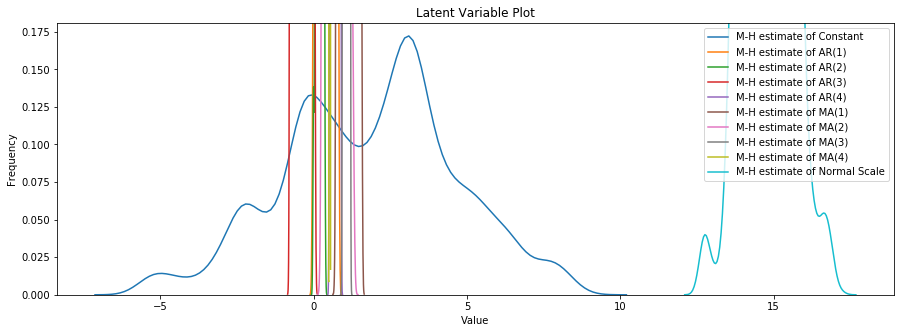

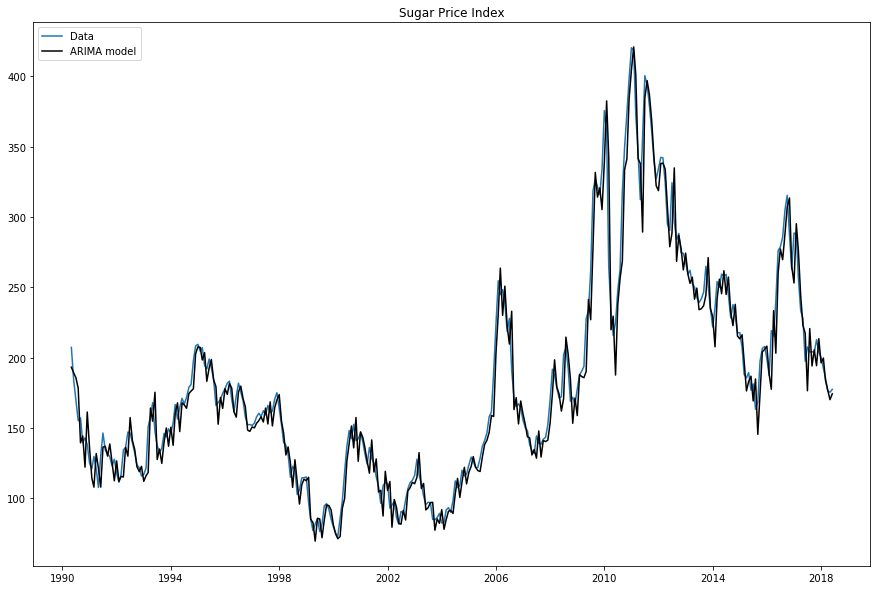

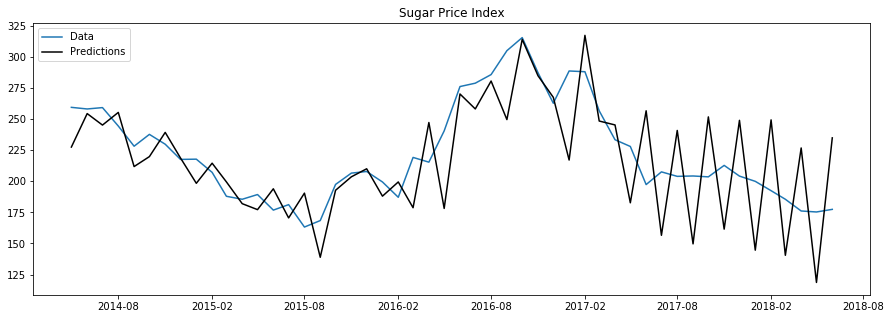

In [85]:
ARIMA_model(indexed_df, 'Sugar Price Index')

# Forecasting

# dashboard code?